In [80]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
import tensorflow as tf
from keras_frcnn import config
from keras import backend as K
from keras.layers import Input
from keras.models import Model
#from keras.backend import set_session
from tensorflow.compat.v1.keras import backend as K
from keras_frcnn import roi_helpers
from matplotlib import pyplot as plt

In [81]:
sys.setrecursionlimit(40000)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)



Device mapping: no known devices.


In [82]:
test_path = 'test'
num_rois = 4
config_filename = 'configSubmission.pickle'
network = 'resnet50'

In [83]:

config_output_filename = config_filename

with open(config_output_filename, 'rb') as f_in:
    C = pickle.load(f_in)

if C.network == 'resnet50':
    import keras_frcnn.resnet as nn
elif C.network == 'vgg':
    import keras_frcnn.vgg as nn

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

img_path = test_path


In [84]:
def format_img_size(img, C):
    """ formats the image size based on config """
    img_min_side = float(C.im_size)
    (height,width,_) = img.shape
        
    if width <= height:
        ratio = img_min_side/width
        new_height = int(ratio * height)
        new_width = int(img_min_side)
    else:
        ratio = img_min_side/height
        new_width = int(ratio * width)
        new_height = int(img_min_side)
    img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
    return img, ratio	

def format_img_channels(img, C):
    """ formats the image channels based on config """
    img = img[:, :, (2, 1, 0)]
    img = img.astype(np.float32)
    img[:, :, 0] -= C.img_channel_mean[0]
    img[:, :, 1] -= C.img_channel_mean[1]
    img[:, :, 2] -= C.img_channel_mean[2]
    img /= C.img_scaling_factor
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    return img

def format_img(img, C):
    """ formats an image for model prediction based on config """
    img, ratio = format_img_size(img, C)
    img = format_img_channels(img, C)
    return img, ratio

# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

    real_x1 = int(round(x1 // ratio))
    real_y1 = int(round(y1 // ratio))
    real_x2 = int(round(x2 // ratio))
    real_y2 = int(round(y2 // ratio))

    return (real_x1, real_y1, real_x2 ,real_y2)


In [85]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)

class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Car', 1: 'bg'}


In [86]:
C.num_rois = int(num_rois)

if C.network == 'resnet50':
    num_features = 1024
elif C.network == 'vgg':
    num_features = 512

if K.image_data_format() == 'channels_first':
    input_shape_img = (3, None, None)
    input_shape_features = (num_features, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, num_features)


In [87]:


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)


In [88]:

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print(f'Loading weights from {C.model_path}')
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')


Loading weights from ./Models/model_frcnn_resnet_annotationCar_Submission.hdf5


In [89]:
all_imgs = []

classes = {}

bbox_threshold = 0.5

visualise = True

set_Overlap_threshold = 0.3


00163.jpg
Elapsed time = 84.92080640792847
[('Car', 93.29919219017029)]


00210.jpg
ROI Shape:  0
Elapsed time = 84.42316961288452
[('Car', 93.26587319374084)]


00378.jpg
ROI Shape:  0
Elapsed time = 80.90078496932983
[('Car', 93.36809515953064)]


00416.jpg
Elapsed time = 12.523255586624146
[('Car', 96.65192365646362)]


00652.jpg
Elapsed time = 11.566025018692017
[('Car', 96.90684080123901)]


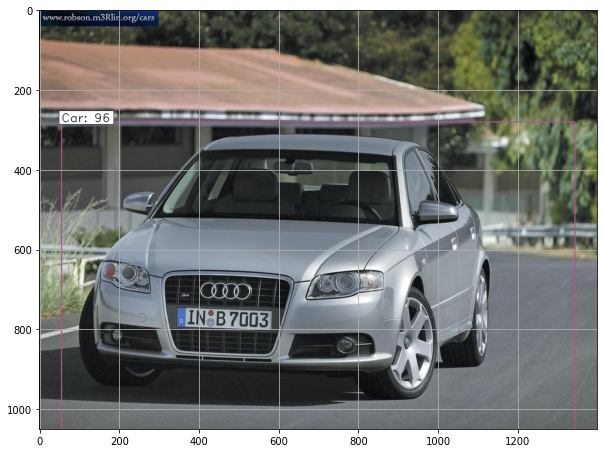

02878.jpg
ROI Shape:  0
Elapsed time = 15.981886386871338
[('Car', 94.79686617851257)]


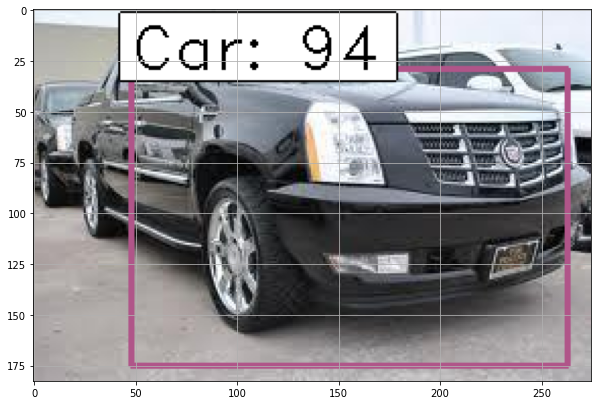

02951.jpg
Elapsed time = 16.470526933670044
[('Car', 98.81171584129333)]


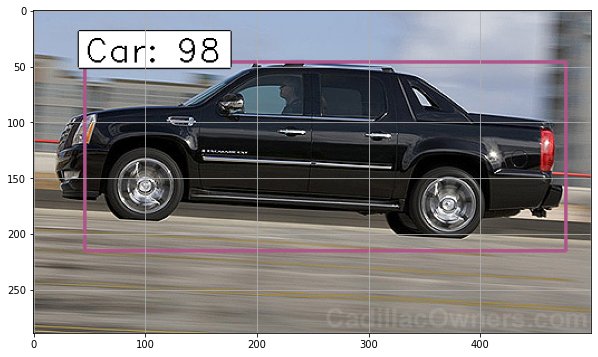

02982.jpg
Elapsed time = 13.5074462890625
[('Car', 91.71497821807861)]


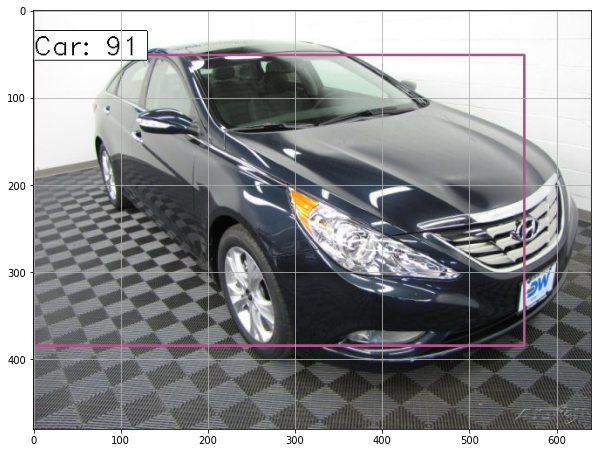

03282.jpg
Elapsed time = 11.964441299438477
[('Car', 52.19247341156006)]


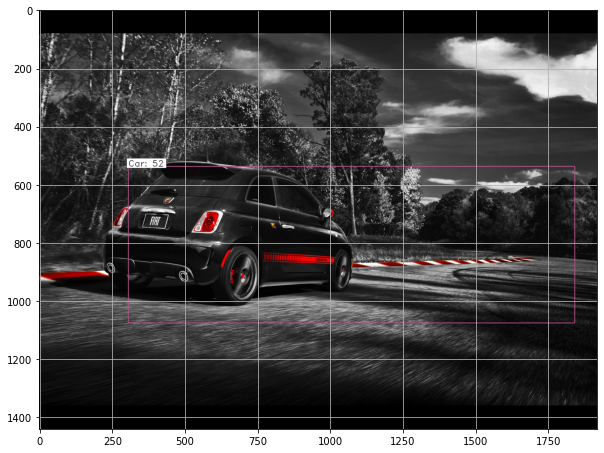

03285.jpg
Elapsed time = 15.135768175125122
[('Car', 98.84118437767029)]


03875.jpg
Elapsed time = 12.150059461593628
[('Car', 93.03996562957764)]


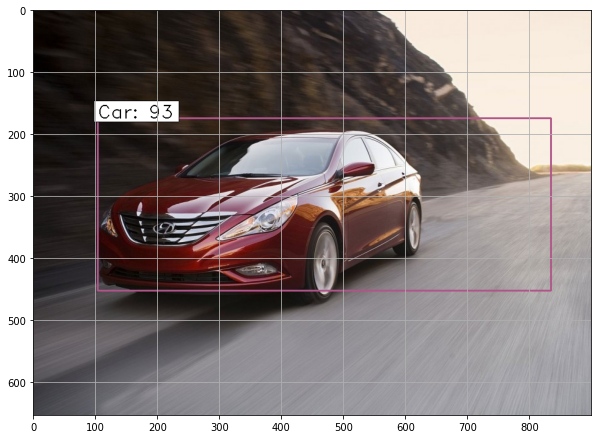

06011.jpg
Elapsed time = 14.138193607330322
[('Car', 97.55369424819946)]


07933.jpg
ROI Shape:  0
Elapsed time = 9.94840121269226
[]


In [90]:
for idx, img_name in enumerate(sorted(os.listdir(img_path))):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(img_path,img_name)
    
    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)

    if K.image_data_format() == 'channels_last':
        X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)
    

    R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.5)#0.7

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            print("ROI Shape: ",ROIs.shape[1])
            break

        if jk == R.shape[0]//C.num_rois:
            #pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):
            #print("np max:",np.max(P_cls[0, ii, :]))
            #print("np argmax:",np.argmax(P_cls[0, ii, :]))
            #print(np.max(P_cls[0, ii, :]) < bbox_threshold)
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]
            #print('class name:',cls_name)
            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=set_Overlap_threshold)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),2)

            textLabel = f'{key}: {int(100*new_probs[jk])}'
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 2)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print(f'Elapsed time = {time.time() - st}')
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()
    
    cv2.imwrite('./results_imgs-fp-mappen-test/{}.png'.format(os.path.splitext(str(img_name))[0]),img)

In [91]:
def format_img_map(img, C):
	"""Format image for mAP. Resize original image to C.im_size (300 in here)

	Args:
		img: cv2 image
		C: config

	Returns:
		img: Scaled and normalized image with expanding dimension
		fx: ratio for width scaling
		fy: ratio for height scaling
	"""

	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	# Change image channel from BGR to RGB
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	# Change img shape from (height, width, channel) to (channel, height, width)
	img = np.transpose(img, (2, 0, 1))
	# Expand one dimension at axis 0
	# img shape becames (1, channel, height, width)
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [92]:
def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):
	"""Convert rpn layer to roi bboxes

	Args: (num_anchors = 9)
		rpn_layer: output layer for rpn classification 
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 9) if resized image is 400 width and 300
		regr_layer: output layer for rpn regression
			shape (1, feature_map.height, feature_map.width, num_anchors)
			Might be (1, 18, 25, 36) if resized image is 400 width and 300
		C: config
		use_regr: Wether to use bboxes regression in rpn
		max_boxes: max bboxes number for non-max-suppression (NMS)
		overlap_thresh: If iou in NMS is larger than this threshold, drop the box

	Returns:
		result: boxes from non-max-suppression (shape=(300, 4))
			boxes: coordinates for bboxes (on the feature map)
	"""
	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	# A.shape = (4, feature_map.height, feature_map.width, num_anchors) 
	# Might be (4, 18, 25, 9) if resized image is 400 width and 300
	# A is the coordinates for 9 anchors for every point in the feature map 
	# => all 18x25x9=4050 anchors cooridnates
	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			# anchor_x = (128 * 1) / 16 = 8  => width of current anchor
			# anchor_y = (128 * 2) / 16 = 16 => height of current anchor
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride
			
			# curr_layer: 0~8 (9 anchors)
			# the Kth anchor of all position in the feature map (9th in total)
			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] # shape => (18, 25, 4)
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)

			# Create 18x25 mesh grid
			# For every point in x, there are all the y points and vice versa
			# X.shape = (18, 25)
			# Y.shape = (18, 25)
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))

			# Calculate anchor position and size for each feature map point
			A[0, :, :, curr_layer] = X - anchor_x/2 # Top left x coordinate
			A[1, :, :, curr_layer] = Y - anchor_y/2 # Top left y coordinate
			A[2, :, :, curr_layer] = anchor_x       # width of current anchor
			A[3, :, :, curr_layer] = anchor_y       # height of current anchor

			# Apply regression to x, y, w and h if there is rpn regression layer
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			# Avoid width and height exceeding 1
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			# Convert (x, y , w, h) to (x1, y1, x2, y2)
			# x1, y1 is top left coordinate
			# x2, y2 is bottom right coordinate
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			# Avoid bboxes drawn outside the feature map
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  # shape=(4050, 4)
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                   # shape=(4050,)

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	# Find out the bboxes which is illegal and delete them from bboxes list
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	# Apply non_max_suppression
	# Only extract the bboxes. Don't need rpn probs in the later process
	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

In [93]:
def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
	# code used from here: http://www.pyimagesearch.com/2015/02/16/faster-non-maximum-suppression-python/
	# if there are no boxes, return an empty list
  
    # Process explanation:
    #   Step 1: Sort the probs list
    #   Step 2: Find the larget prob 'Last' in the list and save it to the pick list
    #   Step 3: Calculate the IoU with 'Last' box and other boxes in the list. If the IoU is larger than overlap_threshold, delete the box from list
    #   Step 4: Repeat step 2 and step 3 until there is no item in the probs list 
	if len(boxes) == 0:
		return []

	# grab the coordinates of the bounding boxes
	x1 = boxes[:, 0]
	y1 = boxes[:, 1]
	x2 = boxes[:, 2]
	y2 = boxes[:, 3]

	np.testing.assert_array_less(x1, x2)
	np.testing.assert_array_less(y1, y2)

	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")

	# initialize the list of picked indexes	
	pick = []

	# calculate the areas
	area = (x2 - x1) * (y2 - y1)

	# sort the bounding boxes 
	idxs = np.argsort(probs)

	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)

		# find the intersection

		xx1_int = np.maximum(x1[i], x1[idxs[:last]])
		yy1_int = np.maximum(y1[i], y1[idxs[:last]])
		xx2_int = np.minimum(x2[i], x2[idxs[:last]])
		yy2_int = np.minimum(y2[i], y2[idxs[:last]])

		ww_int = np.maximum(0, xx2_int - xx1_int)
		hh_int = np.maximum(0, yy2_int - yy1_int)

		area_int = ww_int * hh_int

		# find the union
		area_union = area[i] + area[idxs[:last]] - area_int

		# compute the ratio of overlap
		overlap = area_int/(area_union + 1e-6)

		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlap_thresh)[0])))

		if len(pick) >= max_boxes:
			break

	# return only the bounding boxes that were picked using the integer data type
	boxes = boxes[pick].astype("int")
	probs = probs[pick]
	return boxes, probs

def apply_regr_np(X, T):
	"""Apply regression layer to all anchors in one feature map

	Args:
		X: shape=(4, 18, 25) the current anchor type for all points in the feature map
		T: regression layer shape=(4, 18, 25)

	Returns:
		X: regressed position and size for current anchor
	"""
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
    # Apply regression to x, y, w and h
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

In [94]:
def get_map(pred, gt, f):
    T = {}
    P = {}
    iou_val = []
    fx, fy = f

    for bbox in gt:
        bbox['bbox_matched'] = False

    pred_probs = np.array([s['prob'] for s in pred])
    box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

    for box_idx in box_idx_sorted_by_prob:
        pred_box = pred[box_idx]
        pred_class = pred_box['class']
        pred_x1 = pred_box['x1']
        pred_x2 = pred_box['x2']
        pred_y1 = pred_box['y1']
        pred_y2 = pred_box['y2']
        pred_prob = pred_box['prob']
        if pred_class not in P:
            P[pred_class] = []
            T[pred_class] = []
        P[pred_class].append(pred_prob)
        found_match = False

        for gt_box in gt:
            gt_class = gt_box['class']
            gt_x1 = gt_box['x1']/fx
            gt_x2 = gt_box['x2']/fx
            gt_y1 = gt_box['y1']/fy
            gt_y2 = gt_box['y2']/fy
            gt_seen = gt_box['bbox_matched']
            if gt_class != pred_class:
                continue
            if gt_seen:
                continue
            iou_map = iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
            if iou_map >= 0.5:
                found_match = True
                gt_box['bbox_matched'] = True
                break
            else:
                continue

        T[pred_class].append(int(found_match))
        iou_val.append(iou_map)
        
    for gt_box in gt:
        if not gt_box['bbox_matched']:# and not gt_box['difficult']:
            if gt_box['class'] not in P:
                P[gt_box['class']] = []
                T[gt_box['class']] = []

            T[gt_box['class']].append(1)
            P[gt_box['class']].append(0)

    #import pdb
    #pdb.set_trace()
    return T, P, iou_val

In [95]:
def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):
	# a and b should be (x1,y1,x2,y2)

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

In [96]:
from keras_frcnn.simple_parser import get_data
test_path = 'test_annotationAlt_subset.txt' # Test data (annotation file)



In [97]:
st = time.time()
test_imgs, classes_count, class_mapping = get_data(test_path)
print()
print('Spend %0.2f mins to load the data' % ((time.time()-st)/60) )

Parsing annotation files

Spend 0.20 mins to load the data


In [98]:
class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

{0: 'Car', 1: 'bg'}


In [99]:
print(class_mapping[1])

bg


In [100]:
print(class_mapping)

{0: 'Car', 1: 'bg'}


In [101]:
from sklearn.metrics import average_precision_score
set_Overlap_threshold = 0.05

T = {}
P = {}
mAPs = []
iou_map = []
for idx, img_data in enumerate(test_imgs):
    print('{}/{}'.format(idx,len(test_imgs)))
    st = time.time()
    filepath = img_data['filepath']

    img = cv2.imread(filepath)

    X, fx, fy = format_img_map(img, C)

    # Change X (img) shape from (1, channel, height, width) to (1, height, width, channel)
    X = np.transpose(X, (0, 2, 3, 1))

    # get the feature maps and output from the RPN
    [Y1, Y2, F] = model_rpn.predict(X)


    R = rpn_to_roi(Y1, Y2, C, K.image_data_format(), overlap_thresh=0.7)

    # convert from (x1,y1,x2,y2) to (x,y,w,h)
    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    # apply the spatial pyramid pooling to the proposed regions
    bboxes = {}
    probs = {}

    for jk in range(R.shape[0] // C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0] // C.num_rois:
            # pad R
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        # Calculate all classes' bboxes coordinates on resized image (300, 400)
        # Drop 'bg' classes bboxes
        for ii in range(P_cls.shape[1]):

            # If class name is 'bg', continue
            
            if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            # Get class name
            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        # Apply non-max-suppression on final bboxes to get the output bounding boxe
        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=set_Overlap_threshold)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk, :]
            det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
            all_dets.append(det)


    print('Elapsed time = {}'.format(time.time() - st))
    t, p, iouVal = get_map(all_dets, img_data['bboxes'], (fx, fy))
    for key in t.keys():
        if key not in T:
            T[key] = []
            P[key] = []
        T[key].extend(t[key])
        P[key].extend(p[key])
    all_aps = []
    for key in T.keys():
        ap = average_precision_score(T[key], P[key])
        print('{} AP: {}'.format(key, ap))
        all_aps.append(ap)
    print('mAP = {}'.format(np.mean(np.array(all_aps))))
    print('iou = {}'.format(np.mean(iouVal)))
    mAPs.append(np.mean(np.array(all_aps)))
    iou_map.append(iouVal)
    #print(T)
    #print(P)
    


0/392
Elapsed time = 32.741966009140015
Car AP: 1.0
mAP = 1.0
iou = 0.7559077536175892
1/392
Elapsed time = 34.874818325042725
Car AP: 1.0
mAP = 1.0
iou = 0.7964857588181024
2/392
Elapsed time = 36.24521827697754
Car AP: 1.0
mAP = 1.0
iou = 0.8472197678515527
3/392
Elapsed time = 33.63407492637634
Car AP: 1.0
mAP = 1.0
iou = 0.6944144949147638
4/392
Elapsed time = 36.403364181518555
Car AP: 1.0
mAP = 1.0
iou = 0.7761793687891486
5/392
Elapsed time = 36.753870487213135
Car AP: 1.0
mAP = 1.0
iou = 0.7388543519275484
6/392
Elapsed time = 35.38285994529724
Car AP: 0.9999999999999998
mAP = 0.9999999999999998
iou = 0.765095743422759
7/392
Elapsed time = 33.280025482177734
Car AP: 1.0
mAP = 1.0
iou = 0.8219616465875291
8/392
Elapsed time = 35.53082013130188
Car AP: 1.0
mAP = 1.0
iou = 0.8669387305427034
9/392
Elapsed time = 33.31471395492554
Car AP: 1.0
mAP = 1.0
iou = 0.7154771866918065
10/392
Elapsed time = 33.54599094390869
Car AP: 1.0
mAP = 1.0
iou = 0.8480833513429923
11/392
Elapsed time

Elapsed time = 33.18453598022461
Car AP: 0.9882181064122052
mAP = 0.9882181064122052
iou = 0.8906562763045076
75/392
Elapsed time = 35.137638568878174
Car AP: 0.9882216467070523
mAP = 0.9882216467070523
iou = 0.87861215036286
76/392
Elapsed time = 35.356127977371216
Car AP: 0.9885875267540007
mAP = 0.9885875267540007
iou = 0.7465894813416291
77/392
Elapsed time = 33.58508110046387
Car AP: 0.988589523331576
mAP = 0.988589523331576
iou = 0.5394501900424766
78/392
Elapsed time = 36.34874224662781
Car AP: 0.988593037480066
mAP = 0.988593037480066
iou = 0.8069975499143645
79/392
Elapsed time = 35.44459342956543
Car AP: 0.98893581688772
mAP = 0.98893581688772
iou = 0.8270225980206227
80/392
Elapsed time = 33.73634314537048
Car AP: 0.9892628166608071
mAP = 0.9892628166608071
iou = 0.9081899182104027
81/392
Elapsed time = 33.73814916610718
Car AP: 0.9892623330287363
mAP = 0.9892623330287363
iou = 0.8205816948871912
82/392
Elapsed time = 37.36202120780945
Car AP: 0.9895721593147127
mAP = 0.9895

Elapsed time = 32.38357162475586
Car AP: 0.9938734750245122
mAP = 0.9938734750245122
iou = 0.8621988628562436
145/392
Elapsed time = 36.26487326622009
Car AP: 0.9938719893244747
mAP = 0.9938719893244747
iou = 0.8089098676331202
146/392
Elapsed time = 32.87480711936951
Car AP: 0.9938707945868079
mAP = 0.9938707945868079
iou = 0.8518024031924261
147/392
Elapsed time = 33.16624402999878
Car AP: 0.9939738316819376
mAP = 0.9939738316819376
iou = 0.8900018644564355
148/392
Elapsed time = 33.38862729072571
Car AP: 0.9939724938255031
mAP = 0.9939724938255031
iou = 0.7724488949631122
149/392
Elapsed time = 36.662209033966064
Car AP: 0.9940724395484494
mAP = 0.9940724395484494
iou = 0.7687139511470378
150/392
Elapsed time = 34.688109397888184
Car AP: 0.9940709711809081
mAP = 0.9940709711809081
iou = 0.7503849320240804
151/392
Elapsed time = 33.46375823020935
Car AP: 0.9940697683199042
mAP = 0.9940697683199042
iou = 0.835344253215246
152/392
Elapsed time = 36.46247982978821
Car AP: 0.994068822815

Elapsed time = 34.121068477630615
Car AP: 0.9908821560601889
mAP = 0.9908821560601889
iou = 0.7418856259549182
215/392
Elapsed time = 31.88532257080078
Car AP: 0.9909350988214132
mAP = 0.9909350988214132
iou = 0.7561162322502428
216/392
Elapsed time = 36.10842990875244
Car AP: 0.9910420429947427
mAP = 0.9910420429947427
iou = 0.8448026106046287
217/392
Elapsed time = 33.04489517211914
Car AP: 0.9911470039788411
mAP = 0.9911470039788411
iou = 0.7414416921654803
218/392
Elapsed time = 33.52900314331055
Car AP: 0.9911488835849364
mAP = 0.9911488835849364
iou = 0.8288887432974198
219/392
Elapsed time = 36.424816370010376
Car AP: 0.9911509066522477
mAP = 0.9911509066522477
iou = 0.8410664096622231
220/392
Elapsed time = 33.290528297424316
Car AP: 0.9911110818894344
mAP = 0.9911110818894344
iou = 0.8144271797669649
221/392
Elapsed time = 33.056819438934326
Car AP: 0.9911137642800747
mAP = 0.9911137642800747
iou = 0.7059576003092382
222/392
Elapsed time = 35.16092610359192
Car AP: 0.991116575

Elapsed time = 36.87248373031616
Car AP: 0.9904430366641633
mAP = 0.9904430366641633
iou = 0.8804912198396563
285/392
Elapsed time = 44.23145604133606
Car AP: 0.990430165581873
mAP = 0.990430165581873
iou = 0.811675911425796
286/392
Elapsed time = 39.00938820838928
Car AP: 0.9905105408308374
mAP = 0.9905105408308374
iou = 0.703080820281907
287/392
Elapsed time = 39.13524580001831
Car AP: 0.9905344658466557
mAP = 0.9905344658466557
iou = 0.7338850370996319
288/392
Elapsed time = 37.72479844093323
Car AP: 0.9906133932601708
mAP = 0.9906133932601708
iou = 0.8428808190788996
289/392
Elapsed time = 39.98348069190979
Car AP: 0.9906007083704771
mAP = 0.9906007083704771
iou = 0.8735232132783812
290/392
Elapsed time = 37.30827212333679
Car AP: 0.9906785360515655
mAP = 0.9906785360515655
iou = 0.7215064321821644
291/392
Elapsed time = 39.3192880153656
Car AP: 0.9907553634280861
mAP = 0.9907553634280861
iou = 0.7802647298434785
292/392
Elapsed time = 40.545541524887085
Car AP: 0.990831208356349
m

Elapsed time = 34.09275507926941
Car AP: 0.9874419702477815
mAP = 0.9874419702477815
iou = 0.586883068846207
355/392
Elapsed time = 33.690282583236694
Car AP: 0.9874427456807935
mAP = 0.9874427456807935
iou = 0.7117350241874464
356/392
Elapsed time = 31.386853456497192
Car AP: 0.9875355573162375
mAP = 0.9875355573162375
iou = 0.6892057259413811
357/392
Elapsed time = 38.10829567909241
Car AP: 0.9876272148082107
mAP = 0.9876272148082107
iou = 0.7578848670426018
358/392
Elapsed time = 37.0440468788147
Car AP: 0.9876277124340236
mAP = 0.9876277124340236
iou = 0.555811491087469
359/392
Elapsed time = 32.97485613822937
Car AP: 0.9873430187668832
mAP = 0.9873430187668832
iou = 0.4802960513306527
360/392
Elapsed time = 33.786797761917114
Car AP: 0.9872968773758707
mAP = 0.9872968773758707
iou = 0.7785713992149572
361/392
Elapsed time = 31.82426404953003
Car AP: 0.98732220246531
mAP = 0.98732220246531
iou = 0.7988687565801821
362/392
Elapsed time = 31.09328532218933
Car AP: 0.9874136900736205


In [104]:
print()
print('mean average precision:', np.mean(np.array(mAPs)))


mean average precision: 0.9907238620791237


In [113]:

def Average(lst):
    s=0.0
    for line in iou_map:
        s+=sum(line)
    
    return s/ len(lst)

In [115]:
print('mean IOU:', Average(iou_map))
print()
print('mean average precision:', np.mean(np.array(mAPs)))

mean IOU: 0.752428285070897

mean average precision: 0.9907238620791237
